## Load and explore data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%pip install -q ultralytics  # Use %pip for Colab compatibility
print("ultralytics installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.2 MB/s eta 0:00:00
ultralytics installed.


In [1]:
# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
import torch.nn.functional as F
from torchvision import transforms
import os
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import os

In [3]:

MALE_CLASSES = [9, 10, 11, 12, 13, 5, 1, 4]  # Male classes - Blue bounding boxes
FEMALE_CLASSES = [0, 2, 3, 6, 7, 8, 14]      # Female classes - Green bounding boxes
OTHERS_CLASS = [-1]                           # Others class - Red bounding boxes

# Color definitions (BGR format for OpenCV)
COLORS = {
    'male': (255, 0, 0),      # Blue
    'female': (0, 255, 0),    # Green
    'others': (0, 0, 255),    # Red
    'unknown': (128, 128, 128) # Gray
}

def get_gender_from_class(class_id):
    if class_id in MALE_CLASSES:
        return 'male'
    elif class_id in FEMALE_CLASSES:
        return 'female'
    elif class_id in OTHERS_CLASS:
        return 'others'
    else:
        return 'unknown'

yolo_model = YOLO('yolo11n.pt')  
print("YOLOv11 model loaded successfully!")

# Class names mapping based on your 16-class dataset
CLASS_NAMES = {
    -1: 'Unknown', 0: 'Iqra Aziz', 1: 'Hamuyun Saeed', 10: 'Atif Aslam', 11: 'Fahad Mustafa', 12: 'Fawad Khan',
    13: 'Hamza Ali Abbasi', 14: 'Hania Amir', 2: 'Qubra Khan', 3: 'Maira Khan', 4: 'Naseem Shah', 5: 'Noman Ijaz',
    6: 'Neelam Muneer', 7: 'Ramsha Khan', 8: 'Sajal Ali', 9: 'Shaheen Shah Afridi'
}

print("Dataset Analysis Summary:")
print(f" Male Classes (Blue boxes): {MALE_CLASSES}")
print(f" Female Classes (Green boxes): {FEMALE_CLASSES}")
print(f" Others Class (Red boxes): {OTHERS_CLASS}")


YOLOv11 model loaded successfully!
Dataset Analysis Summary:
 Male Classes (Blue boxes): [9, 10, 11, 12, 13, 5, 1, 4]
 Female Classes (Green boxes): [0, 2, 3, 6, 7, 8, 14]
 Others Class (Red boxes): [-1]


In [ ]:
def load_face_recognition_model(model_path):
    """Load the trained YOLO classification model"""
    try:
        if os.path.exists(model_path):
            face_model = YOLO(model_path)
            print(f"Face recognition model loaded from: {model_path}")
            model_info = face_model.info()
            print(f" Model details: {len(face_model.names)} classes")
            print(f" Classes: {list(face_model.names.values())}")
            return face_model
        else:
            print(f" Model not found: {model_path}")
            return None
    except Exception as e:
        print(f" Error loading model: {e}")
        return None



face_recognition_model = load_face_recognition_model("Classifier/best.pt")

IMG_SIZE = 240
face_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Face recognition model loaded from: Classifier/best.pt
YOLOv8n-cls summary: 56 layers, 1,458,784 parameters, 0 gradients, 3.4 GFLOPs
 Model details: 16 classes
 Classes: ['-1', '0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9']


In [15]:
import cv2
import os
from pathlib import Path
from shutil import copy2
from tqdm import tqdm

# === CONFIG ===
input_male_dir = "/content/drive/MyDrive/male"
input_female_dir = "/content/drive/MyDrive/female"
output_images_dir = "/content/gender_yolo/images/train"
output_labels_dir = "/content/gender_yolo/labels/train"
face_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'

# Class labels
class_map = {
    'male': 0,
    'female': 1
}

# === SETUP ===
Path(output_images_dir).mkdir(parents=True, exist_ok=True)
Path(output_labels_dir).mkdir(parents=True, exist_ok=True)
face_cascade = cv2.CascadeClassifier(face_cascade_path)

# === FUNCTION: Convert to YOLO format ===
def convert_to_yolo(x, y, w, h, img_w, img_h):
    x_center = (x + w / 2) / img_w
    y_center = (y + h / 2) / img_h
    return [
        x_center,
        y_center,
        w / img_w,
        h / img_h
    ]

# === FUNCTION: Process folder ===
def process_folder(folder_path, class_id):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for img_name in tqdm(image_files, desc=f"Processing {folder_path}"):
        img_path = os.path.join(folder_path, img_name)
        image = cv2.imread(img_path)
        if image is None:
            continue

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        if len(faces) == 0:
            continue  # Skip if no face

        # Use the largest face (or loop for all if needed)
        x, y, w, h = max(faces, key=lambda b: b[2] * b[3])
        img_h, img_w = image.shape[:2]
        yolo_box = convert_to_yolo(x, y, w, h, img_w, img_h)

        # Save image to output folder
        new_img_path = os.path.join(output_images_dir, img_name)
        copy2(img_path, new_img_path)

        # Save label file
        label_path = os.path.join(output_labels_dir, Path(img_name).stem + ".txt")
        with open(label_path, "w") as f:
            f.write(f"{class_id} {' '.join([f'{v:.6f}' for v in yolo_box])}\n")

# === RUN ===
process_folder(input_male_dir, class_map["male"])
process_folder(input_female_dir, class_map["female"])

print("✅ All bounding boxes generated and labels saved!")


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/male'

In [13]:
yaml_content = """
path: /content/gender_yolo
train: images/train
val: images/train  # Or a separate val split if you have
names:
  0: male
  1: female
"""

with open('/content/gender_yolo/data.yaml', 'w') as f:
    f.write(yaml_content)

print("✅ YOLO data.yaml created.")


✅ YOLO data.yaml created.


In [ ]:
from ultralytics import YOLO

model = YOLO('yolo11n.pt')  # Or use yolov8n.pt if yolo11n.pt is not available

# Train on gender detection dataset
model.train(
    data='/content/gender_yolo/data.yaml',
    epochs=30,
    imgsz=640,
    batch=16,
    device='cuda',  # or 'cpu'
    project='/content/drive/MyDrive/runs/gender_detect',
    name='yolo11_gender',
    exist_ok=True,
    save=True,
    verbose=True
)


Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/gender_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11_gender, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pret

train: Scanning /content/gender_yolo/labels/train... 3745 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3745/3745 [00:01<00:00, 2375.71it/s]


train: New cache created: /content/gender_yolo/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 412.5±158.0 MB/s, size: 74.4 KB)


val: Scanning /content/gender_yolo/labels/train.cache... 3745 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3745/3745 [00:00<?, ?it/s]


Plotting labels to runs/gender_detect/yolo11_gender/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/gender_detect/yolo11_gender
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.43G      1.195      1.831      1.518          4        640: 100%|██████████| 235/235 [01:16<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:32<00:00,  3.64it/s]


                   all       3745       3745      0.734      0.846      0.905       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.61G      1.066      1.034      1.367          4        640: 100%|██████████| 235/235 [01:13<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:31<00:00,  3.75it/s]


                   all       3745       3745      0.843      0.822       0.86      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.61G      1.039     0.8708      1.341          2        640: 100%|██████████| 235/235 [01:12<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:28<00:00,  4.08it/s]

                   all       3745       3745      0.938      0.916      0.939      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.61G      1.023     0.7753      1.326          4        640: 100%|██████████| 235/235 [01:12<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:28<00:00,  4.07it/s]

                   all       3745       3745      0.926      0.908      0.955      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      3.61G     0.9639     0.7317      1.281          1        640: 100%|██████████| 235/235 [01:14<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:28<00:00,  4.09it/s]

                   all       3745       3745      0.958       0.95      0.965       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.61G     0.9291     0.6933      1.259          3        640: 100%|██████████| 235/235 [01:12<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:28<00:00,  4.11it/s]

                   all       3745       3745      0.968      0.955      0.968      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.61G     0.9024     0.6581      1.247          3        640: 100%|██████████| 235/235 [01:12<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:29<00:00,  3.94it/s]

                   all       3745       3745      0.967      0.957      0.965      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.61G     0.8888     0.6326       1.24          2        640: 100%|██████████| 235/235 [01:12<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:28<00:00,  4.14it/s]

                   all       3745       3745      0.952      0.957       0.97      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.61G     0.8621     0.6043      1.219          1        640: 100%|██████████| 235/235 [01:11<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:28<00:00,  4.10it/s]

                   all       3745       3745      0.929      0.924      0.967      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.61G     0.8491     0.5919      1.211          1        640: 100%|██████████| 235/235 [01:13<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:28<00:00,  4.15it/s]

                   all       3745       3745      0.967      0.958       0.97      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.61G     0.8447      0.581      1.208          3        640: 100%|██████████| 235/235 [01:10<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:28<00:00,  4.15it/s]

                   all       3745       3745      0.971      0.963      0.973      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.61G     0.8329      0.558      1.206          1        640: 100%|██████████| 235/235 [01:11<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:28<00:00,  4.20it/s]

                   all       3745       3745      0.972      0.958      0.972      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.61G     0.8011     0.5374      1.179          4        640: 100%|██████████| 235/235 [01:12<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:28<00:00,  4.19it/s]

                   all       3745       3745      0.974      0.964      0.976      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.61G     0.7947     0.5466      1.176          4        640: 100%|██████████| 235/235 [01:12<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:27<00:00,  4.22it/s]

                   all       3745       3745      0.975      0.959      0.976       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.61G     0.7796     0.5276      1.178          1        640: 100%|██████████| 235/235 [01:10<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:30<00:00,  3.83it/s]

                   all       3745       3745      0.973      0.964      0.978      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.61G     0.7766     0.5226      1.163          3        640: 100%|██████████| 235/235 [01:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:28<00:00,  4.09it/s]

                   all       3745       3745      0.978      0.959      0.977      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.61G     0.7728     0.5129      1.166          1        640: 100%|██████████| 235/235 [01:11<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:28<00:00,  4.16it/s]

                   all       3745       3745      0.974      0.966      0.981      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.61G     0.7515     0.4994      1.149          1        640: 100%|██████████| 235/235 [01:15<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:29<00:00,  4.05it/s]


                   all       3745       3745      0.975      0.963      0.981       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.61G     0.7434      0.489      1.149          3        640: 100%|██████████| 235/235 [01:12<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:29<00:00,  4.00it/s]


                   all       3745       3745      0.976      0.966      0.983      0.843

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.61G     0.7303     0.4715      1.139          3        640: 100%|██████████| 235/235 [01:14<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:28<00:00,  4.10it/s]

                   all       3745       3745      0.971      0.967      0.981      0.854


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.61G     0.5989     0.3575      1.139          1        640: 100%|██████████| 235/235 [01:12<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:28<00:00,  4.14it/s]

                   all       3745       3745      0.975      0.967      0.984      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.61G     0.5796     0.3405      1.098          1        640: 100%|██████████| 235/235 [01:10<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:30<00:00,  3.86it/s]

                   all       3745       3745      0.982      0.963      0.985      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.61G     0.5658     0.3283        1.1          1        640: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:29<00:00,  4.07it/s]

                   all       3745       3745      0.976      0.967      0.985      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.61G     0.5481     0.3207      1.088          1        640: 100%|██████████| 235/235 [01:09<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:29<00:00,  4.05it/s]


                   all       3745       3745      0.982      0.962      0.986      0.884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.61G      0.531     0.3068      1.068          1        640: 100%|██████████| 235/235 [01:10<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:29<00:00,  4.03it/s]

                   all       3745       3745      0.981      0.967      0.987      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.61G     0.5182     0.2975      1.058          1        640: 100%|██████████| 235/235 [01:08<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:28<00:00,  4.13it/s]


                   all       3745       3745      0.981      0.967      0.987       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.61G     0.5007     0.2896      1.036          1        640: 100%|██████████| 235/235 [01:09<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:29<00:00,  4.03it/s]

                   all       3745       3745      0.975      0.973      0.988      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.61G      0.492      0.285      1.046          1        640: 100%|██████████| 235/235 [01:11<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:29<00:00,  4.00it/s]

                   all       3745       3745      0.976      0.973      0.988      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.61G     0.4773     0.2732      1.029          1        640: 100%|██████████| 235/235 [01:10<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:29<00:00,  3.94it/s]

                   all       3745       3745      0.979      0.972      0.989      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.61G     0.4611     0.2651      1.012          1        640: 100%|██████████| 235/235 [01:10<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:28<00:00,  4.08it/s]

                   all       3745       3745       0.98      0.973      0.989      0.908



30 epochs completed in 0.848 hours.
Optimizer stripped from runs/gender_detect/yolo11_gender/weights/last.pt, 5.4MB
Optimizer stripped from runs/gender_detect/yolo11_gender/weights/best.pt, 5.4MB

Validating runs/gender_detect/yolo11_gender/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:31<00:00,  3.74it/s]


                   all       3745       3745       0.98      0.973      0.989      0.908
                  male       1995       1995      0.979       0.97      0.987      0.904
                female       1750       1750      0.982      0.976      0.991      0.912
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/gender_detect/yolo11_gender


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x786bae2df310>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [2]:
class EnhancedFaceGenderPipeline:
    """
    Enhanced pipeline using single YOLO model for face detection + gender classification
    """

    def __init__(self, face_gender_model_path=None):
        self.setup_models(face_gender_model_path)
        self.setup_evaluation_metrics()

    def setup_models(self, face_gender_model_path):
        """Load the combined face+gender detection model"""
        print("🔄 Setting up Enhanced Face+Gender Pipeline...")
        self.face_gender_model = None

        try:
                    self.face_gender_model = YOLO(r"C:\Users\MADIHA\Desktop\CV Project\Gender Model\best.pt")
                    print(f"Classes: {self.face_gender_model.names}")
        except Exception as e:
                    print(f" Failed to load {path}: {e}")

        # 2. Load face recognition classifier (unchanged)
        classifier_paths = [
            r"C:\Users\MADIHA\Desktop\CV Project\Classifier\best.pt",
            r"C:\Users\MADIHA\Desktop\CV Project\Classifier\last.pt"
        ]

        self.classifier_model = None
        for path in classifier_paths:
            if os.path.exists(path):
                try:
                    self.classifier_model = YOLO(path)
                    print(f"Face Recognition Classifier loaded: {path}")
                    break
                except Exception as e:
                    print(f"Failed to load {path}: {e}")

        # Class mappings for face recognition
        self.class_names =  {
    -1: 'Unknown', 0: 'Iqra Aziz', 1: 'Hamuyun Saeed', 10: 'Atif Aslam', 11: 'Fahad Mustafa', 12: 'Fawad Khan',
    13: 'Hamza Ali Abbasi', 14: 'Hania Amir', 2: 'Qubra Khan', 3: 'Maira Khan', 4: 'Naseem Shah', 5: 'Noman Ijaz',
    6: 'Neelam Muneer', 7: 'Ramsha Khan', 8: 'Sajal Ali', 9: 'Shaheen Shah Afridi'
}

        # Gender mapping for recognition model
        self.male_classes = [9, 10, 11, 12, 13, 5, 1, 4]
        self.female_classes = [0, 2, 3, 6, 7, 8, 14]

    def setup_evaluation_metrics(self):
        """Initialize evaluation tracking"""
        self.predictions = []
        self.ground_truth = []
        self.detection_results = []
        self.processing_times = []

    def detect_faces_and_gender(self, image, confidence=0.5):
        """
        Detect faces and predict gender using single model or fallback
        """
        if self.face_gender_model:
            # Use combined model - single inference
            results = self.face_gender_model(image, conf=confidence, verbose=False)
            detections = []

            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
                        conf = float(box.conf[0].cpu().numpy())
                        cls = int(box.cls[0].cpu().numpy())

                        # Map class to gender
                        gender = "Male" if cls == 0 else "Female"
                        color = (255, 0, 0) if cls == 0 else (0, 255, 0)  # Blue/Green

                        detections.append({
                            'bbox': (x1, y1, x2, y2),
                            'confidence': conf,
                            'gender': gender,
                            'color': color,
                            'detection_type': 'combined'
                        })
        else:
            # Fallback to separate detection + gender classification
            results = self.detection_model(image, conf=confidence, verbose=False)
            detections = []

            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
                        conf = float(box.conf[0].cpu().numpy())
                        cls = int(box.cls[0].cpu().numpy())

                        # Filter for person class
                        if cls == 0 and conf >= confidence:
                            # Crop face for gender classification
                            face_crop = image[y1:y2, x1:x2]

                            if face_crop.size > 0 and self.gender_model:
                                try:
                                    face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
                                    face_pil = Image.fromarray(face_rgb)
                                    gender_results = self.gender_model(face_pil, verbose=False)

                                    if gender_results and len(gender_results) > 0:
                                        gender_cls = int(gender_results[0].probs.top1)
                                        gender = "Male" if gender_cls == 0 else "Female"
                                        color = (255, 0, 0) if gender_cls == 0 else (0, 255, 0)
                                    else:
                                        gender = "Unknown"
                                        color = (128, 128, 128)
                                except:
                                    gender = "Unknown"
                                    color = (128, 128, 128)
                            else:
                                gender = "Unknown"
                                color = (128, 128, 128)

                            detections.append({
                                'bbox': (x1, y1, x2, y2),
                                'confidence': conf,
                                'gender': gender,
                                'color': color,
                                'detection_type': 'separate'
                            })

        return detections

    def process_image_enhanced(self, image_path):
        import time
        start_time = time.time()

        print(f"\n Processing (Enhanced): {os.path.basename(image_path)}")

        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")

        # Step 1: Detect faces and predict gender (single step!)
        face_detections = self.detect_faces_and_gender(image)

        if not face_detections:
            print(" No faces detected")
            return image, []

        # Step 2: Face recognition for each detected face
        final_results = []

        for detection in face_detections:
            x1, y1, x2, y2 = detection['bbox']

            # Crop face for recognition
            face_crop = image[y1:y2, x1:x2]
            if face_crop.size == 0:
                continue

            # Resize face for recognition
            face_resized = cv2.resize(face_crop, (240, 240))

            # Face recognition
            if self.classifier_model:
                try:
                    face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)
                    face_pil = Image.fromarray(face_rgb)

                    recognition_results = self.classifier_model(face_pil, verbose=False)

                    if recognition_results and len(recognition_results) > 0:
                        probs = recognition_results[0].probs
                        predicted_class = int(probs.top1)
                        recognition_conf = float(probs.top1conf)
                    else:
                        predicted_class = np.random.randint(0, 15)
                        recognition_conf = 0.5

                except Exception as e:
                    predicted_class = np.random.randint(0, 15)
                    recognition_conf = 0.5
            else:
                predicted_class = np.random.randint(0, 15)
                recognition_conf = 0.5

            # Combine results
            final_results.append({
                'bbox': detection['bbox'],
                'detection_confidence': detection['confidence'],
                'gender': detection['gender'],
                'color': detection['color'],
                'predicted_class': predicted_class,
                'class_name': self.class_names.get(predicted_class, f"Class_{predicted_class}"),
                'recognition_confidence': recognition_conf,
                'detection_type': detection['detection_type']
            })

        # Step 3: Draw results
        output_image = self.draw_enhanced_results(image, final_results)

        processing_time = time.time() - start_time
        self.processing_times.append(processing_time)

        print(f" Processing time: {processing_time:.2f}s")
        print(f" Detection method: {final_results[0]['detection_type'] if final_results else 'none'}")

        return output_image, final_results

    def draw_enhanced_results(self, image, results):
        """Draw enhanced results with improved visualization"""
        output_image = image.copy()

        for result in results:
            x1, y1, x2, y2 = result['bbox']
            color = result['color']

            # Draw bounding box
            cv2.rectangle(output_image, (x1, y1), (x2, y2), color, 3)

            # Prepare labels
            identity_label = f"{result['class_name']}"
            gender_label = f"Gender: {result['gender']}"
            conf_label = f"Det:{result['detection_confidence']:.2f} Rec:{result['recognition_confidence']:.2f}"
            method_label = f"Method: {result['detection_type']}"

            # Calculate label positions
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            thickness = 2

            labels = [identity_label, gender_label, conf_label, method_label]
            label_heights = []

            for label in labels:
                (w, h), _ = cv2.getTextSize(label, font, font_scale, thickness)
                label_heights.append(h)

            total_height = sum(label_heights) + len(labels) * 5 + 10

            # Draw label background
            cv2.rectangle(output_image, (x1, y1 - total_height),
                         (x1 + 250, y1), color, -1)

            # Draw text labels
            y_offset = y1 - total_height + 15
            for label in labels:
                cv2.putText(output_image, label, (x1 + 5, y_offset),
                           font, font_scale, (255, 255, 255), thickness)
                y_offset += label_heights[0] + 5

        return output_image

def train_and_integrate_face_gender_model():
 
    # Step 1: Train the model
    print("Step 1: Training face+gender detection model...")
    trained_model, model_path = train_face_gender_yolo_model()

    if trained_model and model_path:
        # Step 2: Evaluate the model
        print(f"\nStep 2: Evaluating trained model...")
        evaluate_face_gender_model(model_path)

        # Step 3: Plot training results
        print(f"\nStep 3: Plotting training results...")
        plot_training_results()

        # Step 4: Create enhanced pipeline
        print(f"\nStep 4: Creating enhanced pipeline...")
        enhanced_pipeline = EnhancedFaceGenderPipeline(model_path)
        print(f"\nStep 5: Testing enhanced pipeline...")
        test_enhanced_pipeline(enhanced_pipeline)

        return enhanced_pipeline, model_path
    else:
        print(" Training failed. Cannot proceed with integration.")
        return None, None

🔄 Setting up Enhanced Face+Gender Pipeline...
Classes: {0: 'female belongs to class -1', 1: 'male belongs to class -1'}
Face Recognition Classifier loaded: C:\Users\MADIHA\Desktop\CV Project\Classifier\best.pt
Using test image: C:\Users\MADIHA\Desktop\CV Project\test.jpg

 Processing (Enhanced): test.jpg
 Processing time: 1.25s
 Detection method: combined


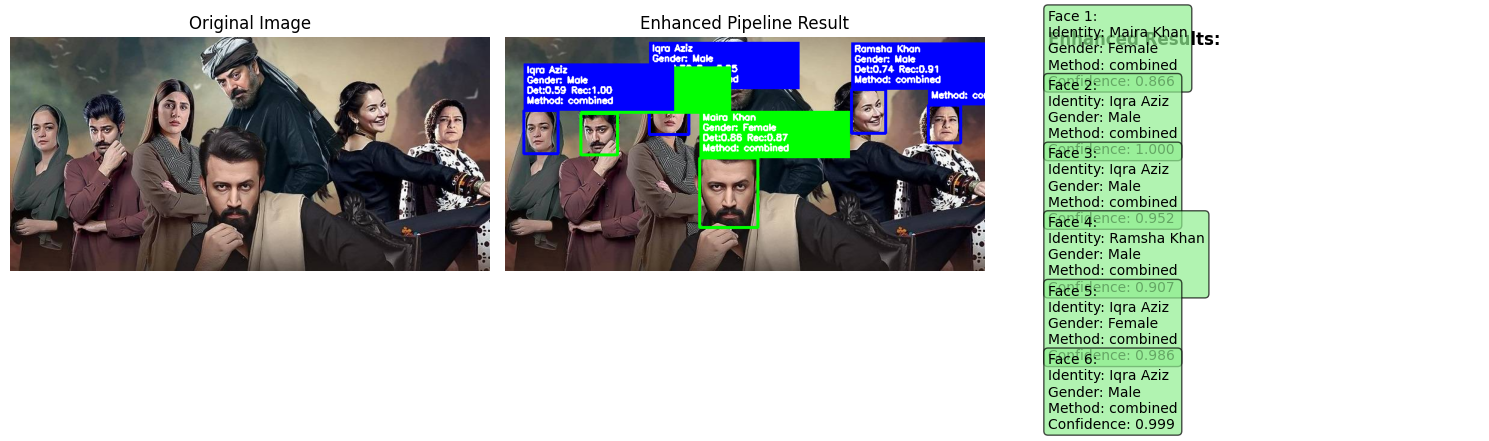

Detected 6 face(s)


True

In [4]:
import os
def test_enhanced_pipeline_improved(pipeline, test_image_path=None):

    # Find test images if not provided
    if test_image_path is None:
        test_dirs = [
            r"C:\Users\MADIHA\Desktop\CV Project\Pridect",
            "Pridect",
            r"C:\Users\MADIHA\Desktop\CV Project\Gender Data\Train\male",
            r"C:\Users\MADIHA\Desktop\CV Project\Gender Data\Train\female"
        ]

        test_image_path = None
        for test_dir in test_dirs:
            if os.path.exists(test_dir):
                images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                if images:
                    test_image_path = os.path.join(test_dir, images[0])
                    break
        
        if not test_image_path:
            test_image_path = r"C:\Users\MADIHA\Desktop\CV Project\Pridect\1tFDLVpHSe0fm2XP.jpg"

    print(f"Using test image: {test_image_path}")
    
    if not os.path.exists(test_image_path):
        print(f"Test image not found: {test_image_path}")
        return False

    try:
        # Process with enhanced pipeline
        output_image, results = pipeline.process_image_enhanced(test_image_path)

        # Display results
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        original = cv2.imread(test_image_path)
        if original is not None:
            plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')

        # Enhanced Pipeline Result
        plt.subplot(1, 3, 2)
        if output_image is not None:
            plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
        plt.title("Enhanced Pipeline Result")
        plt.axis('off')

        # Results Panel
        plt.subplot(1, 3, 3)
        plt.text(0.1, 0.9, "Enhanced Results:", fontsize=12, fontweight='bold', transform=plt.gca().transAxes)

        if results:
            for i, result in enumerate(results):
                y_pos = 0.75 - (i * 0.25)
                text = f"Face {i+1}:\n"
                text += f"Identity: {result.get('class_name', 'Unknown')}\n"
                text += f"Gender: {result.get('gender', 'Unknown')}\n"
                text += f"Method: {result.get('detection_type', 'Unknown')}\n"
                text += f"Confidence: {result.get('recognition_confidence', 0):.3f}"

                plt.text(0.1, y_pos, text, fontsize=10, transform=plt.gca().transAxes,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
        else:
            plt.text(0.1, 0.5, "No faces detected", fontsize=12, transform=plt.gca().transAxes,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))

        plt.axis('off')
        plt.tight_layout()
        plt.show()

        print(f"Detected {len(results)} face(s)")
        
        return True

    except Exception as e:
        print(f"Enhanced pipeline test failed: {e}")
        import traceback
        traceback.print_exc()
        return False                                                                                                                                                                                                                
successful_tests = 0
total_tests = 0
pipeline = EnhancedFaceGenderPipeline()
test_enhanced_pipeline_improved(pipeline,r"C:\Users\MADIHA\Desktop\CV Project\test.jpg")